In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

---- Simulation parameters ----
Generations:    200
Iterations:     300
Total iters:    60000
Signal power:   0.00 dB
Sig cent. freq: -150000.0 Hz
Noise power:    10.00 dB
Noise uncert:   3.00 dB
SNR:            -10.00 dB
Signal length:  0.001024 s
Signal samples: 1024
FFT length:     1024
Num. of bands:  4
Band to detect: 1
Band noise est: 3
Est. hist.:     10
Covari. size:   20
---- Simulation stats theory ----
Prob false alarm: 0.1000
Prob detection:   0.9998
Threshold:        1.0811
---- Running simulation ----
Using 8 processes on 8 cores


100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


---- Simulation stats ----
Prob false alarm theory:      0.1000
Prob false alarm sim:         0.0934
Prob detection theory (post): 0.9711
Prob detection sim:           0.9534
---- Distribution stats ----
Sig present mean: 1.3999
Sig absent  mean: 0.9868
Sig present var:  0.0079
Sig absent  var:  0.0050
Sig present std:  0.0889
Sig absent  std:  0.0706


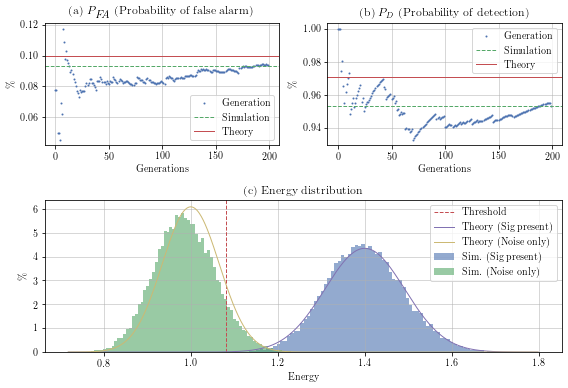

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-deep')
import time

from specsens import util


def prints(gens,
           pfas,
           pds,
           theo_pfa,
           theo_pd,
           eng_both,
           eng_noise,
           n=None,
           signal_power=None,
           noise_power=None,
           threshold=None,
           num_bands=1,
           num_est_samples=0,
           no_info=False,
           bins=100,
           hist_only=False):

    plt.figure(figsize=(8, 5.5))

    gs = gridspec.GridSpec(2, 2, height_ratios=[0.8, 1.0])

    ax0 = plt.subplot(gs[0])
    ax0.plot(0,
             pfas[0],
             'o',
             c='C0',
             markersize=1,
             label=r'Generation',
             aa=True)
    for i in range(1, gens):
        inter = np.mean(pfas[0:i])
        ax0.plot(i, inter, 'o', c='C0', markersize=1, aa=True)
    ax0.axhline(np.mean(pfas),
                c='C1',
                ls='--',
                linewidth=1,
                label=r'Simulation',
                aa=True)
    ax0.axhline(theo_pfa, c='C2', linewidth=1, label=r'Theory', aa=True)
    ax0.legend(loc=0)
    ax0.set_xlabel(r'Generations')
    ax0.set_ylabel(r'$\%$')
    ax0.set_title(r'(a) $P_{\textit{FA}}$ (Probability of false alarm)')
    ax0.grid(linewidth=0.5)

    ax1 = plt.subplot(gs[1])
    ax1.plot(0,
             pds[0],
             'o',
             c='C0',
             markersize=1,
             label=r'Generation',
             aa=True)
    for i in range(1, gens):
        inter = np.mean(pds[0:i])
        ax1.plot(i, inter, 'o', c='C0', markersize=1, aa=True)
    ax1.axhline(np.mean(pds),
                c='C1',
                ls='--',
                linewidth=1,
                label=r'Simulation',
                aa=True)
    ax1.axhline(theo_pd, c='C2', linewidth=1, label=r'Theory', aa=True)
    ax1.legend(loc=0)
    ax1.set_xlabel(r'Generations')
    ax1.set_ylabel(r'$\%$')
    ax1.set_title(r'(b) $P_D$ (Probability of detection)')
    ax1.grid(linewidth=0.5)

    gs = gridspec.GridSpec(2, 1, height_ratios=[0.8, 1.0])
    ax2 = plt.subplot(gs[1])

    # histogram if we had no information about what is what
    if no_info:
        ax2.hist(np.concatenate((eng_both, eng_noise)),
                 bins,
                 density=True,
                 color='black',
                 alpha=0.5,
                 aa=True,
                 label=r'No information')

    # histograms from simulations
    ax2.hist(eng_both,
             bins,
             density=True,
             color='C0',
             alpha=0.6,
             aa=True,
             label=r'Sim. (Sig present)')
    ax2.hist(eng_noise,
             bins,
             density=True,
             color='C1',
             alpha=0.6,
             aa=True,
             label=r'Sim. (Noise only)')
    ax2.axvline(threshold,
                c='C2',
                ls='--',
                linewidth=1,
                aa=True,
                label=r'Threshold')

    if not hist_only:
        x = np.linspace(np.amin(np.concatenate((eng_both, eng_noise))),
                        np.amax(np.concatenate((eng_both, eng_noise))), 1000)

        # CLT pdfs
        if num_est_samples > 0:  # use estimation stats when using estimation
            snr = util.dB_to_factor_power(
                signal_power) / util.dB_to_factor_power(noise_power)
            snr *= num_bands
            noise_dist = stats.norm.pdf(x,
                                        loc=1,
                                        scale=np.sqrt((n + num_est_samples) /
                                                      (n * num_est_samples)))
            both_dist = stats.norm.pdf(
                x,
                loc=1. + snr,
                scale=np.sqrt(
                    (n + num_est_samples) / (n * num_est_samples)) * (1 + snr))

        else:  # use the regular stats otherwise
            noise_pow = util.dB_to_factor_power(noise_power)
            both_pow = noise_pow + util.dB_to_factor_power(
                signal_power) * num_bands

            #             noise_dist = stats.norm.pdf(x,
            #                                         loc=n * noise_pow,
            #                                         scale=np.sqrt(n * noise_pow**2))
            #             both_dist = stats.norm.pdf(x,
            #                                        loc=n * both_pow,
            #                                        scale=np.sqrt(n * both_pow**2))

            # Chi2 pdfs (not usable for noise estimation)
            noise_dist = stats.chi2.pdf(x,
                                        df=2. * n,
                                        loc=0.,
                                        scale=noise_pow / 2.)
            both_dist = stats.chi2.pdf(x,
                                       df=2. * n,
                                       loc=0.,
                                       scale=both_pow / 2.)
        ax2.plot(x,
                 both_dist,
                 c='C3',
                 linewidth=1,
                 aa=True,
                 label=r'Theory (Sig present)')
        ax2.plot(x,
                 noise_dist,
                 c='C4',
                 linewidth=1,
                 aa=True,
                 label=r'Theory (Noise only)')

    ax2.legend(loc=0)
    ax2.grid(linewidth=0.5)
    ax2.set_xlabel(r'Energy')
    ax2.set_title(r'(c) Energy distribution')
    ax2.set_ylabel(r'$\%$')


    plt.tight_layout()
    plt.savefig('out/chap5/noise_estimation_eigenvalue_detection.pdf')

    print('---- Distribution stats ----')
    print('Sig present mean: %.4f' % (np.mean(eng_both)))
    print('Sig absent  mean: %.4f' % (np.mean(eng_noise)))
    print('Sig present var:  %.4f' % (np.var(eng_both)))
    print('Sig absent  var:  %.4f' % (np.var(eng_noise)))
    print('Sig present std:  %.4f' % (np.std(eng_both)))
    print('Sig absent  std:  %.4f' % (np.std(eng_noise)))
        


import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import multiprocessing as mp
import tqdm
from functools import partial

from specsens import util
from specsens import util_sim
from specsens import WirelessMicrophone
from specsens import WhiteGaussianNoise
from specsens import WidebandEnergyDetector
from specsens import Stft
from specsens import est_stats
from specsens import noise_est as noise_esti


def generation(f_sample, length_sec, itrs, noise_power, signal_power,
               noise_uncert, threshold, window, fft_len, num_bands, f_center,
               band_to_detect, band_noise_est, noise_est_hist, cov_size,
               seeds):

    # create new signal objects
    wm = WirelessMicrophone(f_sample=f_sample, t_sec=length_sec, seed=seeds[0])
    wgn = WhiteGaussianNoise(f_sample=f_sample,
                             t_sec=length_sec,
                             seed=seeds[1])

    # local rng
    rng = np.random.default_rng(seeds[2])

    # calculate noise power with uncertainty
    gen_noise_power = rng.normal(loc=noise_power, scale=noise_uncert)

    # noise estimation for this generation
    wm_est = WirelessMicrophone(f_sample=f_sample,
                                t_sec=length_sec * noise_est_hist,
                                seed=seeds[0])
    wgn_est = WhiteGaussianNoise(f_sample=f_sample,
                                 t_sec=length_sec * noise_est_hist,
                                 seed=seeds[1])
    sig_est = wm.soft(f_center=f_center, power=signal_power, dB=True)
    noi_est = wgn.signal(power=gen_noise_power, dB=True)
    both_est = sig_est + noi_est
    noise_estimate = noise_esti.estimate_quick(both_est,
                                               int(f_sample * length_sec),
                                               l=cov_size,
                                               dB=False)

    # store results in 'result' array energies in 'energy' array
    result = np.array([])
    energy = np.array([])

    # list for noise estimation
    # noise_est_list = np.array([])

    # list for noise estimation used with hacky histogram fix
    noise_est_list2 = np.array([])

    # 'inner' interations loop
    for _ in range(itrs):

        # generate signal
        sig = wm.soft(f_center=f_center, power=signal_power, dB=True)

        # generate noise
        noise = wgn.signal(power=gen_noise_power, dB=True)

        # randomly decide whether signal should be present
        sig_present = rng.choice([True, False])
        if sig_present:
            both = sig + noise
        else:
            both = noise

        # create a Short Time Fourier Transform object
        sft = Stft(n=fft_len, window=window)

        # use the stft to transform the signal into the frequency domain
        f, psd = sft.stft(both, f_sample, normalized=False, dB=False)

        # create a Wideband Energy Detector object
        fed = WidebandEnergyDetector(num_bands=num_bands,
                                     f_sample=f_sample,
                                     fft_len=fft_len,
                                     freqs=f)

        # compute energy for all bands
        bands = fed.detect(psd)

        # compute noise power from 'free' band
        noise_est = bands[band_noise_est] / (fft_len / num_bands)

        # handle size of noise estimation list
        # if np.size(noise_est_list) >= noise_est_hist:
        #      noise_est_list = np.delete(noise_est_list, 0)
        #  noise_est_list = np.append(noise_est_list, noise_est)

        # get noise estimate from noise estimation list
        # not using the list here, since we are using eigenvalue noise estimation
        # noise_estimate = np.mean(noise_est_list)

        # energy detector
        eng = bands[band_to_detect]

        # remove noise dependency and normalize
        eng /= noise_estimate * (fft_len / num_bands)

        # threshold
        sig_detected = eng > threshold

        # --- very hacky ---
        # compensation for nonlinearity in energy distributions
        # this just influences / fixes the histogram plots
        noise2 = wgn.signal(power=noise_power, dB=True)
        both2 = sig + noise2
        f2, psd2 = sft.stft(both2, f_sample, normalized=False, dB=False)
        bands2 = fed.detect(psd2)
        noise_est2 = bands2[band_noise_est] / (fft_len / num_bands)
        if np.size(noise_est_list2) >= noise_est_hist:
            noise_est_list2 = np.delete(noise_est_list2, 0)
        noise_est_list2 = np.append(noise_est_list2, noise_est2)
        if sig_present:
            noise_estimate2 = np.mean(noise_est_list2)
            eng2 = bands2[band_to_detect]
            eng2 /= noise_estimate2 * (fft_len / num_bands)
            eng = eng2
        # --- hacky part end ---

        # log detection outcome
        if sig_present and sig_detected:
            result = np.append(result, 1)
        elif sig_present and not sig_detected:
            result = np.append(result, 2)
        elif not sig_present and sig_detected:
            result = np.append(result, 3)
        else:
            result = np.append(result, 4)

        # log energy
        energy = np.append(energy, eng)

    # calculate statistics and store in arrays
    pfa_tmp = np.sum(result == 3) / (np.sum(result == 3) + np.sum(result == 4))
    pd_tmp = np.sum(result == 1) / (np.sum(result == 1) + np.sum(result == 2))

    return pfa_tmp, pd_tmp, energy, result, gen_noise_power


def eigenvalue_estimation_sim(
    gens=50,  # generations, number of environments
    itrs=300,  # iterations, number of tests in each environment
    f_sample=1e6,  # in Hz
    signal_power=0.,  # in dB
    f_center=-1e5,  # signal center frequency
    noise_power=0.,  # in dB
    length_sec=None,  # length of each section in seconds
    num_samples=None,  # number of samples
    theo_pfa=0.1,  # probability of false alarm
    threshold=None,  # threshold used for detection
    noise_uncert=0.0,  # standard deviation of the noise normal distribution
    seed=None,  # random seed used for rng
    num_procs=None,  # number of processes to run in parallel
    window='box',  # window used with fft
    fft_len=1024,  # samples used for fft
    num_bands=1,  # total number of bands
    band_to_detect=0.,  # band to 'search' for signal in
    band_noise_est=None,  # band to use for noise estimation
    noise_est_hist=1,  # depth of noise estimation buffer
    cov_size=50):  # size of covariance matrix

    # set number of processes used
    if num_procs is None:
        num_procs = mp.cpu_count()
    assert num_procs > 0, 'num_procs must be greater than 0'
    assert num_procs <= gens, 'num_procs must be less or equal to gens'

    # check and calculate length (in seconds and number of samples)
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    # calculate threshold
    if threshold is None:
        threshold = est_stats.thr(pfa=theo_pfa,
                                  n=fft_len / num_bands,
#                                   m=(fft_len / num_bands) * noise_est_hist)
                                  m=fft_len * noise_est_hist)

    print('---- Simulation parameters ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_power))
    print('Sig cent. freq: %.1f Hz' % (f_center))
    print('Noise power:    %.2f dB' % (noise_power))
    print('Noise uncert:   %.2f dB' % (noise_uncert))
    print('SNR:            %.2f dB' % (signal_power - noise_power))
    print('Signal length:  %.6f s' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    print('FFT length:     %d' % (fft_len))
    print('Num. of bands:  %d' % (num_bands))
    print('Band to detect: %d' % (band_to_detect))
    print('Band noise est: %d' % (band_noise_est))
    print('Est. hist.:     %d' % (noise_est_hist))
    print('Covari. size:   %d' % (cov_size))

    # calculate pd (only needed for prints)
    theo_pd = est_stats.pd(noise_power,
                           signal_power,
                           threshold,
                           n=fft_len / num_bands,
#                            m=(fft_len / num_bands) * noise_est_hist,
                           m=fft_len * noise_est_hist,
                           num_bands=num_bands)

    print('---- Simulation stats theory ----')
    print('Prob false alarm: %.4f' % (theo_pfa))
    print('Prob detection:   %.4f' % (theo_pd))
    print('Threshold:        %.4f' % (threshold))

    print('---- Running simulation ----')
    print('Using %d processes on %d cores' % (num_procs, mp.cpu_count()))

    pfas = list()  # probability of false alarm list
    pds = list()  # probability of detection list
    current_time = None  # time variable used for 'runtime_stats'

    # generate child seeds for wm and wgn
    seed_seq = np.random.SeedSequence(seed)
    seeds = list(
        zip(seed_seq.spawn(gens), seed_seq.spawn(gens), seed_seq.spawn(gens)))

    # prepare parallel execution
    p = mp.Pool(processes=num_procs)
    f = partial(generation, f_sample, length_sec, itrs, noise_power,
                signal_power, noise_uncert, threshold, window, fft_len,
                num_bands, f_center, band_to_detect, band_noise_est,
                noise_est_hist, cov_size)

    # run simulation while showing progress bar
    res = list(tqdm.tqdm(p.imap(f, seeds), total=gens))

    # cleanup parallel execution
    p.close()
    p.join()

    # 'unwrap' res tuples
    pfas = [r[0] for r in res]
    pds = [r[1] for r in res]
    energies = np.ravel([r[2] for r in res])
    results = np.ravel([r[3] for r in res])
    gen_noise_powers = np.ravel([r[4] for r in res])

    # calulate theo_pd again, but take nonlinearity into account
    theo_pd_post = list(
        map(
            lambda x: est_stats.pd(x,
                                   signal_power,
                                   threshold,
                                   n=fft_len / num_bands,
                                   m=(fft_len / num_bands) * noise_est_hist,
                                   num_bands=num_bands), gen_noise_powers))

    # compute stats from lists
    pfa = np.sum(pfas) / gens
    pd = np.sum(pds) / gens

    # compute energy distributions
    engs_both = energies[np.where(results <= 2)[0]]
    engs_noise = energies[np.where(results > 2)[0]]

    print('---- Simulation stats ----')
    print('Prob false alarm theory:      %.4f' % (theo_pfa))
    print('Prob false alarm sim:         %.4f' % (pfa))
    print('Prob detection theory (post): %.4f' % (np.mean(theo_pd_post)))
    print('Prob detection sim:           %.4f' % (pd))

    prints(gens,
           pfas,
           pds,
           theo_pfa,
           np.mean(theo_pd_post),
           engs_both,
           engs_noise,
           fft_len // num_bands,
           signal_power,
           noise_power,
           threshold,
           num_bands,
           num_est_samples=(fft_len / num_bands) * noise_est_hist,
           no_info=False)

    return pfa, pd


_ = eigenvalue_estimation_sim(
    gens=200,  # generations, number of environments
    itrs=300,  # iterations, number of tests in each environment
    f_sample=1e6,  # in Hz
    signal_power=0.0,  # in dB
    noise_power=10,  # in dB
    length_sec=0.001024,  # length of each sample in seconds
    theo_pfa=0.1,  # probability of false alarm
    noise_uncert=
    3.0,  # standard deviation of the noise normal distribution in dB
    num_procs=None,  # number of processes to run in parallel
    seed=0,  # set seed for reproducibility
    window='box',  # window used with fft
    fft_len=1024,  # samples used for fft
    num_bands=4,  # total number of bands
    f_center=-1.5e5,  # signal center frequency
    band_to_detect=1,  # band to 'search' for signal in
    band_noise_est=3,  # band to use for noise estimation
    noise_est_hist=10,  # depth of noise estimation buffer
    cov_size=20)